In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize_scalar
import datetime
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [8]:
def bayesian_beta_model(historical_pct: float, days_elapsed: int, days_in_month: int, 
                       current_mentions: int = 0, confidence: float = 0.8) -> Dict:
    """
    Bayesian model using Beta distribution for phrase occurrence probability.
    
    Args:
        historical_pct: Historical percentage of months with 1+ mentions (0-1)
        days_elapsed: Days elapsed in current month
        days_in_month: Total days in current month
        current_mentions: Number of mentions so far this month
        confidence: Confidence level for historical data (affects prior strength)
    
    Returns:
        Dictionary with probability estimates and confidence intervals
    """
    # If already mentioned this month, probability is 1.0
    if current_mentions > 0:
        return {
            'probability': 1.0,
            'method': 'bayesian_beta',
            'confidence_interval': (1.0, 1.0),
            'reasoning': 'Already mentioned this month'
        }
    
    # Convert confidence to effective sample size for prior
    effective_n = int(confidence * 100)  # Higher confidence = stronger prior
    
    # Beta prior parameters based on historical data
    alpha_prior = historical_pct * effective_n + 1
    beta_prior = (1 - historical_pct) * effective_n + 1
    
    # Days remaining as "trials" where phrase could be mentioned
    days_remaining = days_in_month - days_elapsed
    
    # Update with current month data (no mentions so far)
    alpha_posterior = alpha_prior
    beta_posterior = beta_prior + days_elapsed  # Each day without mention is "failure"
    
    # Probability of at least one mention in remaining days
    daily_prob = alpha_posterior / (alpha_posterior + beta_posterior)
    prob_no_mention_remaining = (1 - daily_prob) ** days_remaining
    prob_at_least_one = 1 - prob_no_mention_remaining
    
    # Confidence interval using Beta distribution
    ci_lower = stats.beta.ppf(0.025, alpha_posterior, beta_posterior)
    ci_upper = stats.beta.ppf(0.975, alpha_posterior, beta_posterior)
    
    return {
        'probability': prob_at_least_one,
        'daily_probability': daily_prob,
        'method': 'bayesian_beta',
        'confidence_interval': (ci_lower, ci_upper),
        'prior_strength': effective_n,
        'days_remaining': days_remaining
    }


In [9]:
def poisson_time_decay_model(historical_pct: float, days_elapsed: int, 
                            days_in_month: int, current_mentions: int = 0,
                            decay_factor: float = 0.95) -> Dict:
    """
    Poisson process model with time-dependent intensity.
    
    Args:
        historical_pct: Historical percentage of months with 1+ mentions
        days_elapsed: Days elapsed in current month
        days_in_month: Total days in current month
        current_mentions: Number of mentions so far this month
        decay_factor: Daily decay in mention probability (0-1)
    
    Returns:
        Dictionary with probability estimates
    """
    if current_mentions > 0:
        return {
            'probability': 1.0,
            'method': 'poisson_decay',
            'reasoning': 'Already mentioned this month'
        }
    
    # Convert historical percentage to initial daily rate
    # Assume uniform distribution initially, then apply decay
    initial_daily_rate = -np.log(1 - historical_pct) / days_in_month
    
    # Calculate remaining probability with decay
    days_remaining = days_in_month - days_elapsed
    total_remaining_intensity = 0
    
    for day in range(days_remaining):
        day_intensity = initial_daily_rate * (decay_factor ** (days_elapsed + day))
        total_remaining_intensity += day_intensity
    
    # Probability of at least one mention
    prob_at_least_one = 1 - np.exp(-total_remaining_intensity)
    
    return {
        'probability': prob_at_least_one,
        'method': 'poisson_decay',
        'initial_daily_rate': initial_daily_rate,
        'total_remaining_intensity': total_remaining_intensity,
        'decay_factor': decay_factor
    }


In [10]:
def logistic_time_model(historical_pct: float, days_elapsed: int, 
                       days_in_month: int, current_mentions: int = 0,
                       steepness: float = 2.0) -> Dict:
    """
    Logistic model where probability changes based on month progression.
    """
    if current_mentions > 0:
        return {'probability': 1.0, 'method': 'logistic_time', 'reasoning': 'Already mentioned this month'}
    
    progress = days_elapsed / days_in_month
    base_logit = np.log(historical_pct / (1 - historical_pct + 1e-10))
    time_adjustment = -steepness * progress
    adjusted_logit = base_logit + time_adjustment
    probability = 1 / (1 + np.exp(-adjusted_logit))
    
    return {
        'probability': probability,
        'method': 'logistic_time',
        'progress': progress,
        'steepness': steepness
    }

def ensemble_prediction(historical_pct: float, days_elapsed: int, 
                       days_in_month: int, current_mentions: int = 0,
                       weights: Dict[str, float] = None) -> Dict:
    """
    Combine multiple models for ensemble prediction.
    """
    if weights is None:
        weights = {'bayesian': 0.4, 'poisson': 0.3, 'logistic': 0.3}
    
    # Get predictions from all models
    models = {
        'bayesian': bayesian_beta_model(historical_pct, days_elapsed, days_in_month, current_mentions),
        'poisson': poisson_time_decay_model(historical_pct, days_elapsed, days_in_month, current_mentions),
        'logistic': logistic_time_model(historical_pct, days_elapsed, days_in_month, current_mentions)
    }
    
    # Calculate weighted ensemble probability
    ensemble_prob = sum(weights[model] * models[model]['probability'] 
                       for model in weights.keys())
    
    return {
        'ensemble_probability': ensemble_prob,
        'individual_models': models,
        'weights': weights,
        'method': 'ensemble'
    }


In [11]:
## Example Usage and Analysis

def analyze_phrase_probability(phrase: str, historical_pct: float, 
                              days_elapsed: int, days_in_month: int = 31,
                              current_mentions: int = 0):
    """
    Comprehensive analysis of phrase mention probability.
    """
    print(f"\n=== Phrase Probability Analysis: '{phrase}' ===")
    print(f"Historical percentage of months with 1+ mentions: {historical_pct:.1%}")
    print(f"Days elapsed in current month: {days_elapsed}/{days_in_month}")
    print(f"Current mentions this month: {current_mentions}")
    print(f"Days remaining: {days_in_month - days_elapsed}")
    
    # Get ensemble prediction
    result = ensemble_prediction(historical_pct, days_elapsed, days_in_month, current_mentions)
    
    print(f"\n🎯 ENSEMBLE PREDICTION: {result['ensemble_probability']:.1%}")
    
    print("\n📊 Individual Model Results:")
    for model_name, model_result in result['individual_models'].items():
        prob = model_result['probability']
        print(f"  {model_name.capitalize():>10}: {prob:.1%}")
    
    return result


In [12]:
# Example scenarios - run these to see the models in action!

scenarios = [
    {"phrase": "fake news", "historical_pct": 0.85, "days_elapsed": 5, "current_mentions": 0},
    {"phrase": "witch hunt", "historical_pct": 0.60, "days_elapsed": 15, "current_mentions": 0},
    {"phrase": "deep state", "historical_pct": 0.40, "days_elapsed": 25, "current_mentions": 0},
    {"phrase": "crooked joe", "historical_pct": 0.70, "days_elapsed": 10, "current_mentions": 1},
]

results = []
for scenario in scenarios:
    result = analyze_phrase_probability(**scenario)
    results.append({**scenario, 'prediction': result['ensemble_probability']})



=== Phrase Probability Analysis: 'fake news' ===
Historical percentage of months with 1+ mentions: 85.0%
Days elapsed in current month: 5/31
Current mentions this month: 0
Days remaining: 26

🎯 ENSEMBLE PREDICTION: 79.2%

📊 Individual Model Results:
    Bayesian: 100.0%
     Poisson: 50.2%
    Logistic: 80.4%

=== Phrase Probability Analysis: 'witch hunt' ===
Historical percentage of months with 1+ mentions: 60.0%
Days elapsed in current month: 15/31
Current mentions this month: 0
Days remaining: 16

🎯 ENSEMBLE PREDICTION: 55.2%

📊 Individual Model Results:
    Bayesian: 100.0%
     Poisson: 14.2%
    Logistic: 36.3%

=== Phrase Probability Analysis: 'deep state' ===
Historical percentage of months with 1+ mentions: 40.0%
Days elapsed in current month: 25/31
Current mentions this month: 0
Days remaining: 6

🎯 ENSEMBLE PREDICTION: 39.9%

📊 Individual Model Results:
    Bayesian: 89.1%
     Poisson: 2.4%
    Logistic: 11.7%

=== Phrase Probability Analysis: 'crooked joe' ===
Historical 

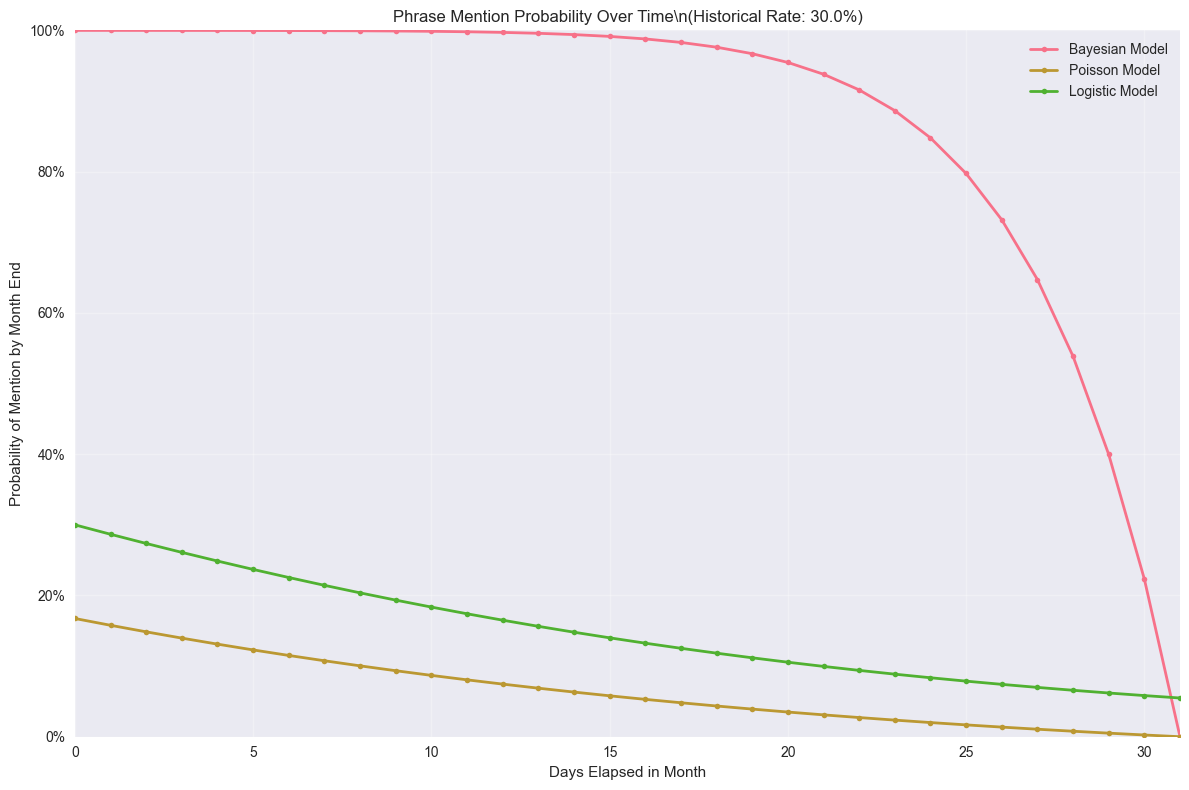

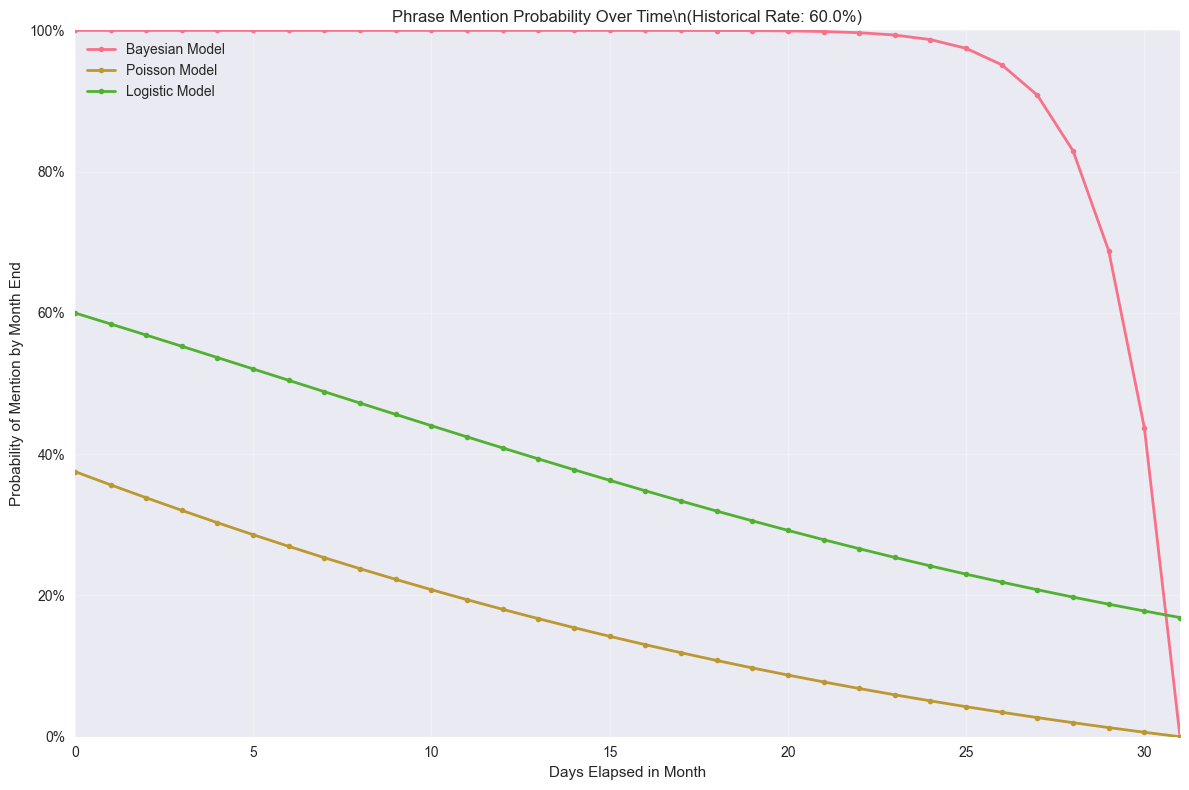

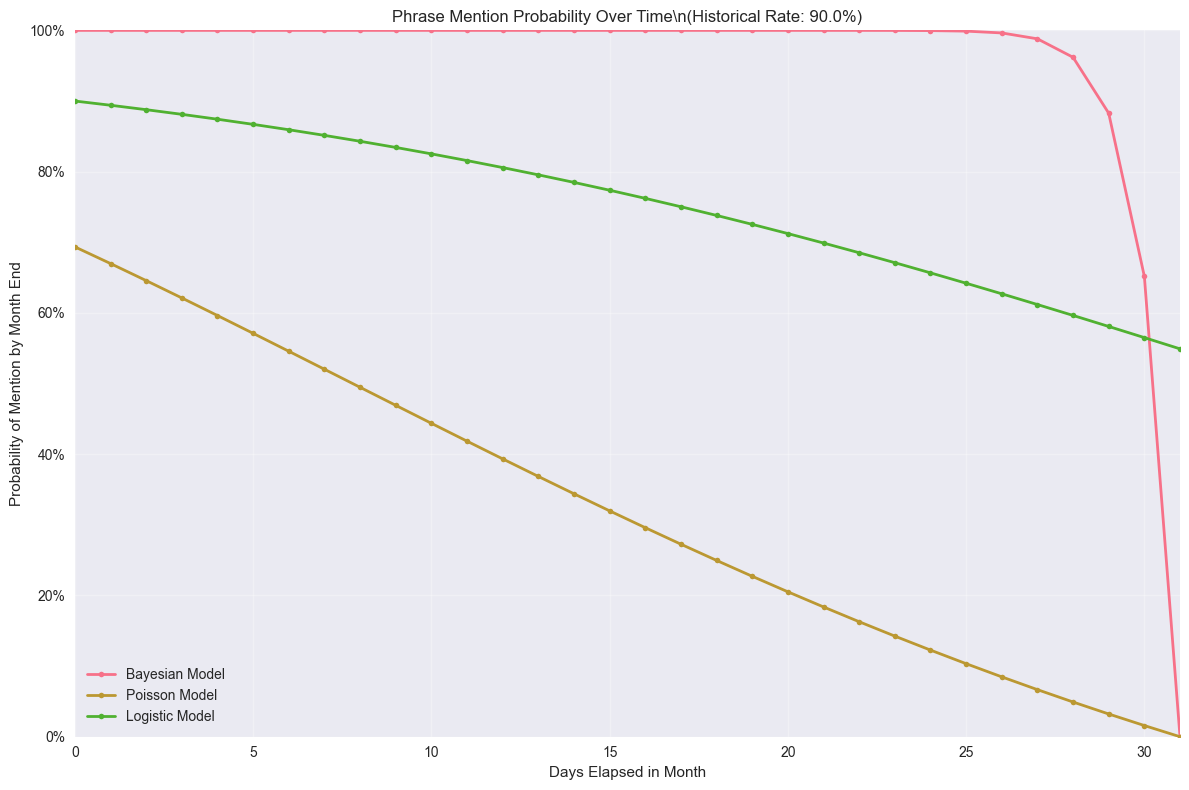

In [13]:
## Visualization of Model Behavior

def plot_probability_over_time(historical_pct: float, days_in_month: int = 31):
    """
    Plot how probability changes as days elapse in the month.
    """
    days = range(0, days_in_month + 1)
    
    # Calculate probabilities for each model over time
    model_probs = {}
    model_names = ['bayesian', 'poisson', 'logistic']
    
    for day in days:
        result = ensemble_prediction(historical_pct, day, days_in_month, 0)
        
        for model_name in model_names:
            if model_name not in model_probs:
                model_probs[model_name] = []
            model_probs[model_name].append(result['individual_models'][model_name]['probability'])
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    for model_name, probs in model_probs.items():
        plt.plot(days, probs, marker='o', linewidth=2, markersize=4, 
                label=f'{model_name.capitalize()} Model')
    
    plt.xlabel('Days Elapsed in Month')
    plt.ylabel('Probability of Mention by Month End')
    plt.title(f'Phrase Mention Probability Over Time\\n(Historical Rate: {historical_pct:.1%})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, days_in_month)
    plt.ylim(0, 1)
    
    # Add percentage labels on y-axis
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
    plt.tight_layout()
    plt.show()

# Plot for different historical rates
for hist_pct in [0.3, 0.6, 0.9]:
    plot_probability_over_time(hist_pct)
